In [1]:
!pip install graphviz
!apt-get install graphviz
!pip install torchview




graphviz is already the newest version (2.42.2-3build2).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [2]:
from transformers import ConvNextFeatureExtractor, ConvNextForImageClassification
import torch
from datasets import load_dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torchview import draw_graph
from sklearn.metrics import accuracy_score,classification_report, roc_auc_score
from tqdm import tqdm_notebook as tqdm
import time
import warnings
warnings.simplefilter("ignore")

%matplotlib inline

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
training_path = '/kaggle/input/brain-tumor/Training/'

In [5]:
IMAGE_SIZE=(224, 224)
batch_size=32
learning_rate = 1e-4
epochs=15

In [6]:
def images_transforms(phase):
    if phase == 'training':
        data_transformation = transforms.Compose([
            transforms.Resize(IMAGE_SIZE),
            transforms.RandomRotation(degrees=(-25,20)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
    else:
        data_transformation=transforms.Compose([
            transforms.Resize(IMAGE_SIZE),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
    return data_transformation

In [7]:
trainset = datasets.ImageFolder(training_path,transform=images_transforms('training'))
len(trainset)

2870

In [8]:
num_classes = len(trainset.classes)
classes = trainset.classes

In [9]:
classes

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [10]:
trainset, valset = torch.utils.data.random_split(trainset, [2228, 642])
len(trainset), len(valset)

(2228, 642)

In [11]:
train_loader = DataLoader(trainset,batch_size=batch_size,shuffle=True)
val_loader = DataLoader(valset,batch_size=batch_size,shuffle=True)

In [12]:
def imshow(img):
    plt.figure(figsize=(20, 20))
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

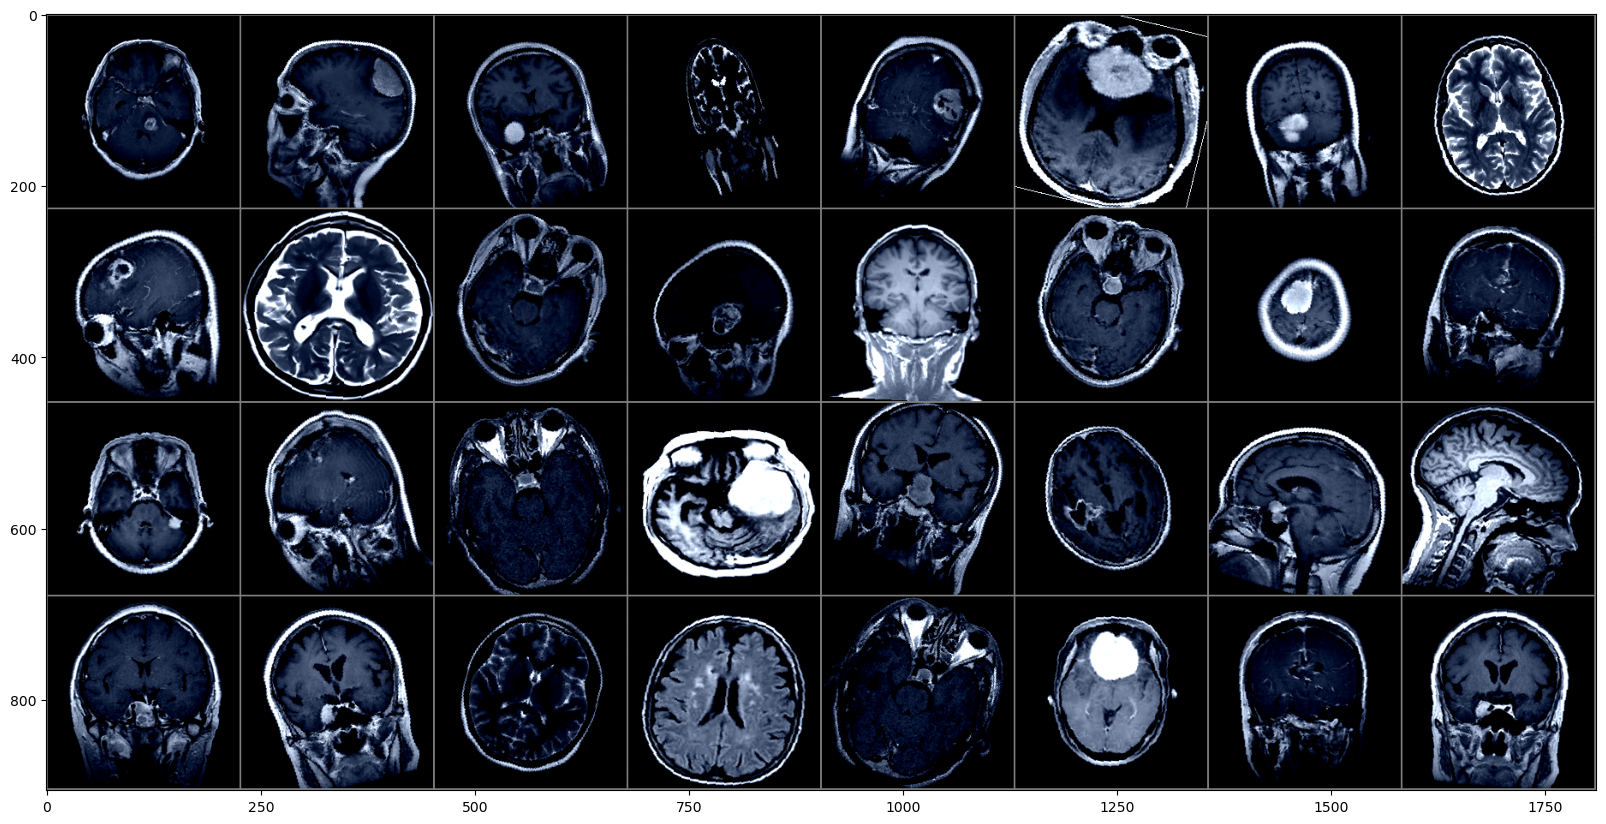

In [13]:
examples = iter(train_loader)
images,labels = next(examples)
imshow(torchvision.utils.make_grid(images))

In [14]:
model = ConvNextForImageClassification.from_pretrained("facebook/convnext-tiny-224")

In [15]:
model = model.convnext
model = model.to(device)

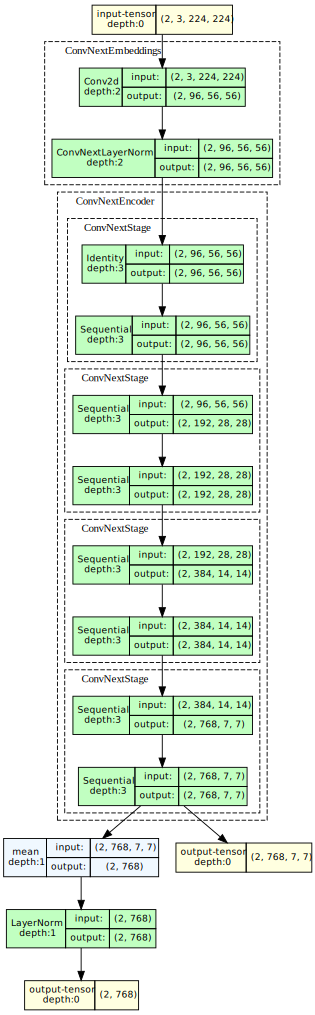

In [16]:
model_graph = draw_graph(model, input_size=(2, 3, 224, 224), device=device, expand_nested=True)
model_graph.visual_graph

In [17]:
sample = torch.rand((2, 3, 224, 224)).to(device)
model(sample)[1].shape

torch.Size([2, 768])

In [18]:
class ConvNextTumorClassifier(nn.Module):
    def __init__(self, base_model, base_model_output_shape, num_classes):
        super().__init__()
        self.base_model = base_model
        self.fc = nn.Sequential(
            nn.Linear(base_model_output_shape, 1024),
            nn.ReLU(),
            nn.Linear(1024, num_classes)
        )
        
    def forward(self, x):
        x = self.base_model(x)[1]
        out = self.fc(x)
        return out

In [19]:
myModel = ConvNextTumorClassifier(model, 768, num_classes)
myModel = myModel.to(device)

criterion=nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

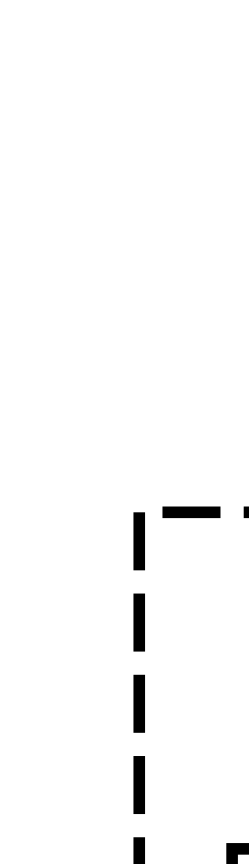

In [20]:
model_graph = draw_graph(myModel, input_size=(1, 3, 224, 224), device=device, expand_nested=True)
model_graph.visual_graph.format = "png"
model_graph.visual_graph.graph_attr.update(dpi='1000')
model_graph.visual_graph.render('model_graph')
model_graph.visual_graph

In [21]:
def train(model,train_loader,criterion,optimizer,val_loader,epochs=25,model_save_path="best_model.pt"):
    train_losses = []
    val_losses = []
    train_auc = []
    val_auc = []
    train_auc_epoch = []
    val_auc_epoch = []
    best_acc = 0.0
    min_loss = np.Inf

    since = time.time()
    y_actual=[]
    y_pred=[]
    for e in range(epochs):
        y_actual=[]
        y_pred=[]
        train_loss = 0.0
        val_loss = 0.0

        # Train the model
        model.train()
        for i, (images, labels) in enumerate(tqdm(train_loader, total=int(len(train_loader)))):
            images = images.to(device).float()
            labels = labels.to(device).long()

            # Forward pass
            outputs = model(images.to(device))
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss and accuracy
            train_loss += loss.item()
            
            _,predictes=torch.max(outputs,1)
            y_actual += list(labels.data.cpu().numpy().flatten()) 
            y_pred += list(predictes.detach().cpu().numpy().flatten())
        train_auc.append(accuracy_score(y_actual, y_pred))

        # Evaluate the model
        model.eval()
        for i, (images, labels) in enumerate(tqdm(val_loader, total=int(len(val_loader)))):
            images = images.to(device).float()
            labels = labels.to(device).long()

            # Forward pass
            outputs = model(images.to(device))
            loss = criterion(outputs, labels)

            # Loss and accuracy
            val_loss += loss.item()
            _,predictes=torch.max(outputs,1)
            y_actual += list(labels.data.cpu().numpy().flatten()) 
            y_pred += list(predictes.detach().cpu().numpy().flatten())
        
        val_auc.append(accuracy_score(y_actual, y_pred))

        # Average losses and accuracies
        train_loss = train_loss/len(train_loader)
        val_loss = val_loss/len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        training_auc = train_auc[-1]
        validation_auc = val_auc[-1]
        train_auc_epoch.append(training_auc)
        val_auc_epoch.append(validation_auc)

        # Updating best validation accuracy
        if best_acc < validation_auc:
            best_acc = validation_auc

        # Saving best model
        if min_loss >= val_loss:
            torch.save(model.state_dict(), model_save_path)
            min_loss = val_loss

        print('EPOCH {}/{} Train loss: {:.6f},Validation loss: {:.6f}, Train AUC: {:.4f}  Validation AUC: {:.4f}\n  '.format(e+1, epochs,train_loss,val_loss, training_auc,validation_auc))
        print('-' * 10)
    time_elapsed = time.time() - since
    print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best validation accuracy: {:4f}'.format(best_acc))
    return train_losses,val_losses,train_auc ,val_auc,train_auc_epoch,val_auc_epoch

In [22]:
def test(model,testloader,target_labels):
    with torch.no_grad():
        n_correct=0
        n_samples=0
        y_pred=[]
        y_actual=[]
        for i,(images,labels) in enumerate(testloader):
            images=images.to(device)
            labels=labels.to(device)
            
            outputs=model(images)
            
            y_actual+=list(np.array(labels.detach().to('cpu')).flatten())
        # value ,index
            _,predictes=torch.max(outputs,1)
            y_pred+=list(np.array(predictes.detach().to('cpu')).flatten())
        # number of samples in current batch
            n_samples+=labels.shape[0]

            n_correct+= (predictes==labels).sum().item()
            
        y_actual=np.array(y_actual).flatten()
        y_pred=np.array(y_pred).flatten()
        acc = classification_report(y_actual,y_pred,target_names=target_labels)
        accuracy = accuracy_score(y_actual, y_pred)
        print(f"{acc}")
        print(f"Accuracy Score : {accuracy}")

In [23]:
train_losses,val_losses,train_auc ,val_auc,train_auc_epoch,val_auc_epoch=train(myModel,train_loader,criterion,optimizer,val_loader,epochs,model_save_path="tumor_model.pt")

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

EPOCH 1/15 Train loss: 0.935129,Validation loss: 0.465660, Train AUC: 0.7186  Validation AUC: 0.7641
  
----------


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

EPOCH 2/15 Train loss: 0.331673,Validation loss: 0.217932, Train AUC: 0.9268  Validation AUC: 0.9341
  
----------


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

EPOCH 3/15 Train loss: 0.180552,Validation loss: 0.198062, Train AUC: 0.9668  Validation AUC: 0.9683
  
----------


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

EPOCH 4/15 Train loss: 0.106245,Validation loss: 0.153894, Train AUC: 0.9861  Validation AUC: 0.9801
  
----------


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

EPOCH 5/15 Train loss: 0.091912,Validation loss: 0.135864, Train AUC: 0.9892  Validation AUC: 0.9854
  
----------


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

EPOCH 6/15 Train loss: 0.084732,Validation loss: 0.137890, Train AUC: 0.9888  Validation AUC: 0.9843
  
----------


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

EPOCH 7/15 Train loss: 0.062613,Validation loss: 0.105668, Train AUC: 0.9960  Validation AUC: 0.9927
  
----------


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

EPOCH 8/15 Train loss: 0.057147,Validation loss: 0.106326, Train AUC: 0.9964  Validation AUC: 0.9927
  
----------


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

EPOCH 9/15 Train loss: 0.048731,Validation loss: 0.090865, Train AUC: 0.9987  Validation AUC: 0.9944
  
----------


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

EPOCH 10/15 Train loss: 0.046591,Validation loss: 0.104596, Train AUC: 0.9987  Validation AUC: 0.9930
  
----------


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

EPOCH 11/15 Train loss: 0.045339,Validation loss: 0.091927, Train AUC: 0.9978  Validation AUC: 0.9934
  
----------


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

EPOCH 12/15 Train loss: 0.053792,Validation loss: 0.071151, Train AUC: 0.9937  Validation AUC: 0.9920
  
----------


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

EPOCH 13/15 Train loss: 0.037950,Validation loss: 0.083844, Train AUC: 0.9996  Validation AUC: 0.9951
  
----------


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

EPOCH 14/15 Train loss: 0.050135,Validation loss: 0.136701, Train AUC: 0.9946  Validation AUC: 0.9868
  
----------


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

EPOCH 15/15 Train loss: 0.063187,Validation loss: 0.100458, Train AUC: 0.9892  Validation AUC: 0.9857
  
----------
Training completed in 10m 55s
Best validation accuracy: 0.995122


In [24]:
test(myModel, train_loader, target_labels=classes)

                  precision    recall  f1-score   support

    glioma_tumor       1.00      1.00      1.00       632
meningioma_tumor       0.99      1.00      1.00       651
        no_tumor       1.00      1.00      1.00       305
 pituitary_tumor       1.00      0.99      1.00       640

        accuracy                           1.00      2228
       macro avg       1.00      1.00      1.00      2228
    weighted avg       1.00      1.00      1.00      2228

Accuracy Score : 0.9973070017953322


In [25]:
test(myModel, val_loader, target_labels=classes)

                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.95      0.98       194
meningioma_tumor       0.92      0.99      0.96       171
        no_tumor       0.98      0.98      0.98        90
 pituitary_tumor       0.99      0.97      0.98       187

        accuracy                           0.97       642
       macro avg       0.97      0.97      0.97       642
    weighted avg       0.97      0.97      0.97       642

Accuracy Score : 0.9719626168224299


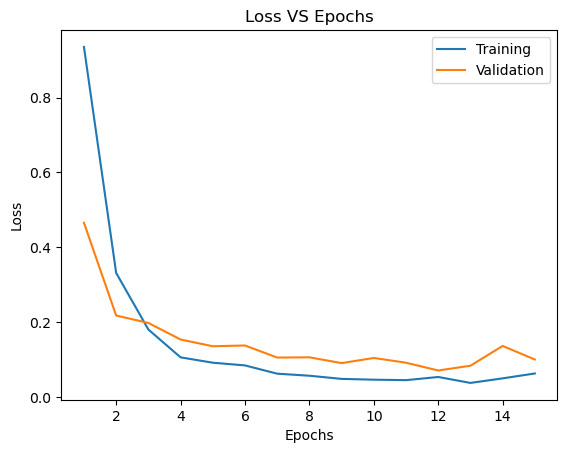

In [26]:
plt.plot(range(1, epochs+1), train_losses, label="Training")
plt.plot(range(1, epochs+1), val_losses, label="Validation")
plt.title("Loss VS Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

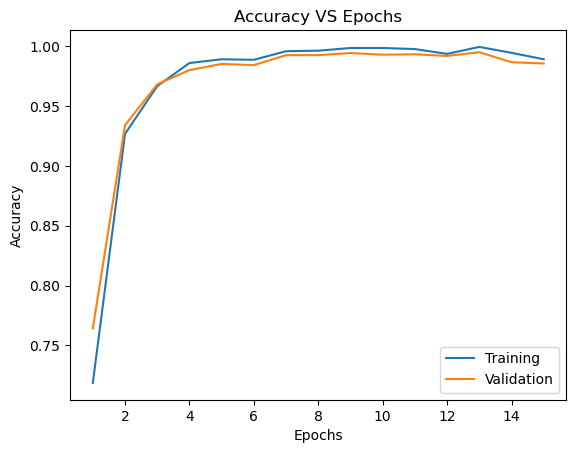

In [27]:
plt.plot(range(1, epochs+1), train_auc, label="Training")
plt.plot(range(1, epochs+1), val_auc, label="Validation")
plt.title("Accuracy VS Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()